In [1]:
# prompt: install and import opendataset

!pip install opendatasets


In [3]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/vencerlanz09/reptiles-and-amphibians-image-dataset")


100%|██████████| 135M/135M [00:05<00:00, 23.5MB/s]


In [4]:
# prompt: collcet the folder names from the base folder

import os

base_folder = "/content/reptiles-and-amphibians-image-dataset"

folders = [f for f in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, f))]

for folder in folders:
    print(folder)


Gecko
Frog
Chameleon
Toad
Crocodile_Alligator
Turtle_Tortoise
Snake
Lizard
Salamander
Iguana


In [5]:
base_dir = '/content/reptiles-and-amphibians-image-dataset'

In [6]:
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)

val_dir = os.path.join(base_dir, 'val')
os.makedirs(val_dir, exist_ok=True)

test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

In [7]:

import shutil

# List of class folder names
class_folders = folders
# Split ratios (adjust these as needed)
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

for folder in class_folders:
    source_folder = os.path.join(base_dir, folder)
    train_dest = os.path.join(train_dir, folder)
    val_dest = os.path.join(val_dir, folder)
    test_dest = os.path.join(test_dir, folder)

    os.makedirs(train_dest, exist_ok=True)
    os.makedirs(val_dest, exist_ok=True)
    os.makedirs(test_dest, exist_ok=True)

    filenames = os.listdir(source_folder)
    num_files = len(filenames)

    num_train = int(num_files * train_ratio)
    num_val = int(num_files * val_ratio)

    train_files = filenames[:num_train]
    val_files = filenames[num_train:num_train + num_val]
    test_files = filenames[num_train + num_val:]

    for file in train_files:
        src_path = os.path.join(source_folder, file)
        dest_path = os.path.join(train_dest, file)
        shutil.copy(src_path, dest_path)

    for file in val_files:
        src_path = os.path.join(source_folder, file)
        dest_path = os.path.join(val_dest, file)
        shutil.copy(src_path, dest_path)

    for file in test_files:
        src_path = os.path.join(source_folder, file)
        dest_path = os.path.join(test_dest, file)
        shutil.copy(src_path, dest_path)



In [9]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
size = 224

batch_size = 32
target_size = (size,size)  # Adjust as needed

train_datagen = ImageDataGenerator(
    rescale=1./255,
    )

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    class_mode='categorical',
    batch_size=batch_size)

val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False)

Found 4833 images belonging to 10 classes.
Found 601 images belonging to 10 classes.
Found 610 images belonging to 10 classes.


In [18]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Add custom classifier on top of base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)  # Add more dense layers if needed
predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

# Combine base model with custom classifier
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze layers in base model
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


29084464/29084464 [==============================] - 1s 0us/step


In [19]:
history = model.fit(train_generator, epochs = 10, validation_data = val_generator)

Epoch 1/10
152/152 [==============================] - 35s 158ms/step - loss: 0.7715 - accuracy: 0.7474 - val_loss: 0.5528 - val_accuracy: 0.8136
Epoch 2/10
152/152 [==============================] - 16s 107ms/step - loss: 0.4934 - accuracy: 0.8245 - val_loss: 0.6144 - val_accuracy: 0.7970
Epoch 3/10
152/152 [==============================] - 17s 112ms/step - loss: 0.4549 - accuracy: 0.8434 - val_loss: 0.5429 - val_accuracy: 0.8070
Epoch 4/10
152/152 [==============================] - 16s 107ms/step - loss: 0.3475 - accuracy: 0.8810 - val_loss: 0.5690 - val_accuracy: 0.8053
Epoch 5/10
152/152 [==============================] - 16s 108ms/step - loss: 0.3062 - accuracy: 0.8891 - val_loss: 0.6341 - val_accuracy: 0.7937
Epoch 6/10
152/152 [==============================] - 17s 114ms/step - loss: 0.2967 - accuracy: 0.8976 - val_loss: 0.5588 - val_accuracy: 0.8003
Epoch 7/10
152/152 [==============================] - 17s 109ms/step - loss: 0.2147 - accuracy: 0.9222 - val_loss: 0.5992 - val_ac

In [20]:
import matplotlib.pyplot as plt

<Figure size 640x480 with 0 Axes>

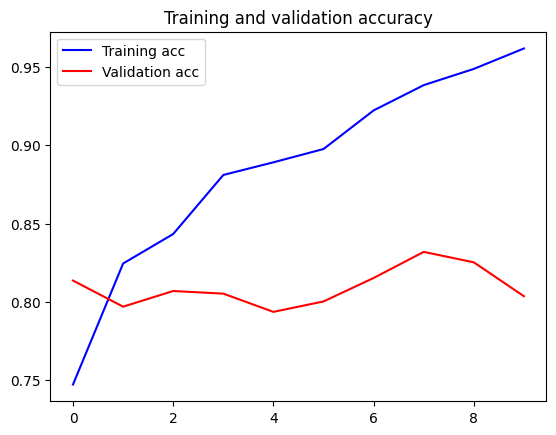

<Figure size 640x480 with 0 Axes>

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

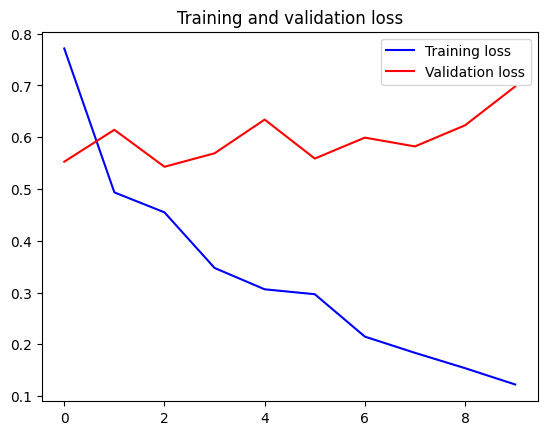

In [22]:
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [23]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

20/20 [==============================] - 4s 217ms/step - loss: 0.7727 - accuracy: 0.8033
Test Loss: 0.7727
Test Accuracy: 0.8033


In [24]:
import numpy as np
test_labels = np.array(test_generator.labels)

20/20 [==============================] - 2s 114ms/step


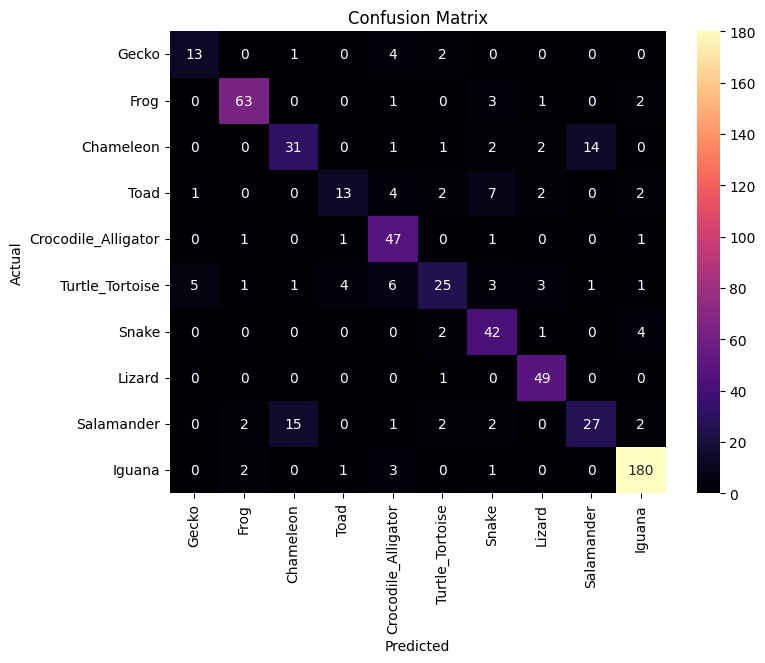

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming you have already trained and compiled your model
# train_ds is your training dataset

# Make predictions using the trained model
predictions = model.predict(test_generator)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Get the actual labels from the dataset

# Calculate the confusion matrix
confusion_mtx = confusion_matrix(test_labels, predicted_labels)
classes = class_folders


import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming you have already trained and compiled your model
# train_ds is your training dataset
classes = class_folders

# Create a Seaborn heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='magma',
            xticklabels=classes, yticklabels=classes)  # Replace 'classes' with your class labels
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()



In [30]:
# prompt: precision, recall and f1 from confusion matrix

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Assuming you have already calculated the confusion matrix as `cm`

# Calculate precision, recall, and F1 score
precision = precision_score(test_labels, predicted_labels, average='macro')
recall = recall_score(test_labels, predicted_labels, average='macro')
f1_score = f1_score(test_labels, predicted_labels, average='macro')

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)


Precision: 0.7456785435052903
Recall: 0.7327888070184085
F1 Score: 0.7305806582895072
